In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupShuffleSplit

In [2]:
# Caricamento del dataset
df = pd.read_csv('data/5g_vanet_dataset.csv')
print(" Dataset Overview:")
print(df.head())

 Dataset Overview:
   Vehicle_ID Vehicle_Type                   Timestamp   Latitude  Longitude  \
0           1          car  2024-09-18 11:18:32.548082  12.974220  77.689259   
1           1          car  2024-09-18 11:18:42.548082  12.975204  77.689494   
2           1          car  2024-09-18 11:18:52.548082  12.974670  77.688675   
3           1          car  2024-09-18 11:19:02.548082  12.975568  77.689606   
4           1          car  2024-09-18 11:19:12.548082  12.976386  77.689124   

    Speed_kmh  Direction_deg  Congestion_Level  Vehicle_Density  Energy_Used  \
0   71.839018      56.166711                87               36     0.800047   
1  112.626325       0.280356                57               22     0.134625   
2    5.599880     350.551987                61               44     2.619749   
3   20.462895      23.418573                 8               26     0.578593   
4   59.421229      12.379868                 3                2     2.183264   

   Remaining_Energy

C:\Users\GABRIELE\AppData\Local\Temp\ipykernel_20776\70578647.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Is_Malicious', palette='Set2')


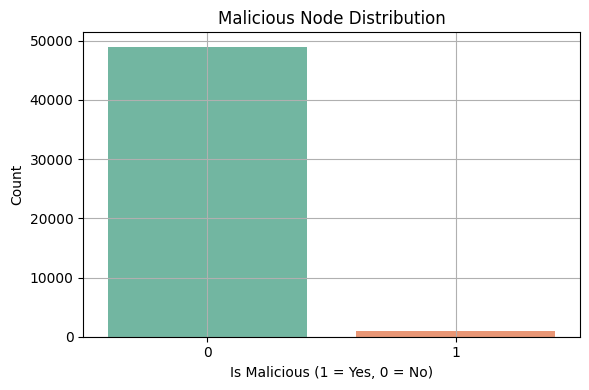

In [9]:
# Distribuzione dei nodi maliziosi vs sani
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Is_Malicious', palette='Set2')
plt.title("Malicious Node Distribution")
plt.xlabel("Is Malicious (1 = Yes, 0 = No)")
plt.ylabel("Count")
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
# Label encoding
df['Attack_Type'] = df['Attack_Type'].fillna(0)
df['Attack_Type'] = df['Attack_Type'].replace('Blackhole', 1)  
df['Attack_Type'] = df['Attack_Type'].replace('Wormhole', 2)
df['Attack_Type'] = df['Attack_Type'].replace('DoS', 3)
df['Attack_Type'] = df['Attack_Type'].astype(int)
print("\n Updated Attack Types:", df['Attack_Type'].unique())

print("\n Unique Vehicle Types:", df['Vehicle_Type'].unique())
df['Vehicle_Type'] = df['Vehicle_Type'].replace('car', 1)
df['Vehicle_Type'] = df['Vehicle_Type'].replace('bus', 2)
df['Vehicle_Type'] = df['Vehicle_Type'].replace('truck', 3)
df['Vehicle_Type'] = df['Vehicle_Type'].replace('van', 4)
df['Vehicle_Type'] = df['Vehicle_Type'].astype(int)
print("\n Updated Vehicle Types:", df['Vehicle_Type'].unique())


 Updated Attack Types: [0 1 2 3]

 Unique Vehicle Types: ['car' 'bus' 'van' 'truck']

 Updated Vehicle Types: [1 2 4 3]


C:\Users\GABRIELE\AppData\Local\Temp\ipykernel_20776\2341654777.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Attack_Type'] = df['Attack_Type'].replace('DoS', 3)
C:\Users\GABRIELE\AppData\Local\Temp\ipykernel_20776\2341654777.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Vehicle_Type'] = df['Vehicle_Type'].replace('van', 4)


In [4]:
# Feature Engineering: Creazione di nuove feature per aiutare la rilevazione
df['Speed_Density_Ratio'] = df['Speed_kmh'] / df['Vehicle_Density']
df['Congestion_Adjusted_Speed'] = df['Speed_kmh'] / (df['Congestion_Level'] + 1)
df['Energy_Communication_Index'] = df['Energy_Used'] / df['Throughput_Mbps']
df['Behavioral_Stress_Index'] = (df['Energy_Used'] * df['Delay_ms']) / df['Packet_Delivery_Ratio']
df['Energy_per_Speed'] = df['Energy_Used'] / df['Speed_kmh']
df['Energy_Ratio'] = df['Energy_Used'] / df['Remaining_Energy']
df['Throughput_per_Delay'] = df['Throughput_Mbps'] / df['Delay_ms']
df['Communication_Stability'] = df['Packet_Delivery_Ratio'] / df['Delay_ms']


In [5]:
#Rimozione di colonne non necessarie o ridondanti
#df.drop(columns=['Vehicle_ID'], inplace=True, errors='ignore')
df.drop(columns=['Vehicle_Type'], inplace=True, errors='ignore')
df.drop(columns=['Timestamp'], inplace=True, errors='ignore')
df.drop(columns=['Latitude'], inplace=True, errors='ignore')
df.drop(columns=['Longitude'], inplace=True, errors='ignore')
#df.drop(columns=['Attack_Type'], inplace=True, errors='ignore') 

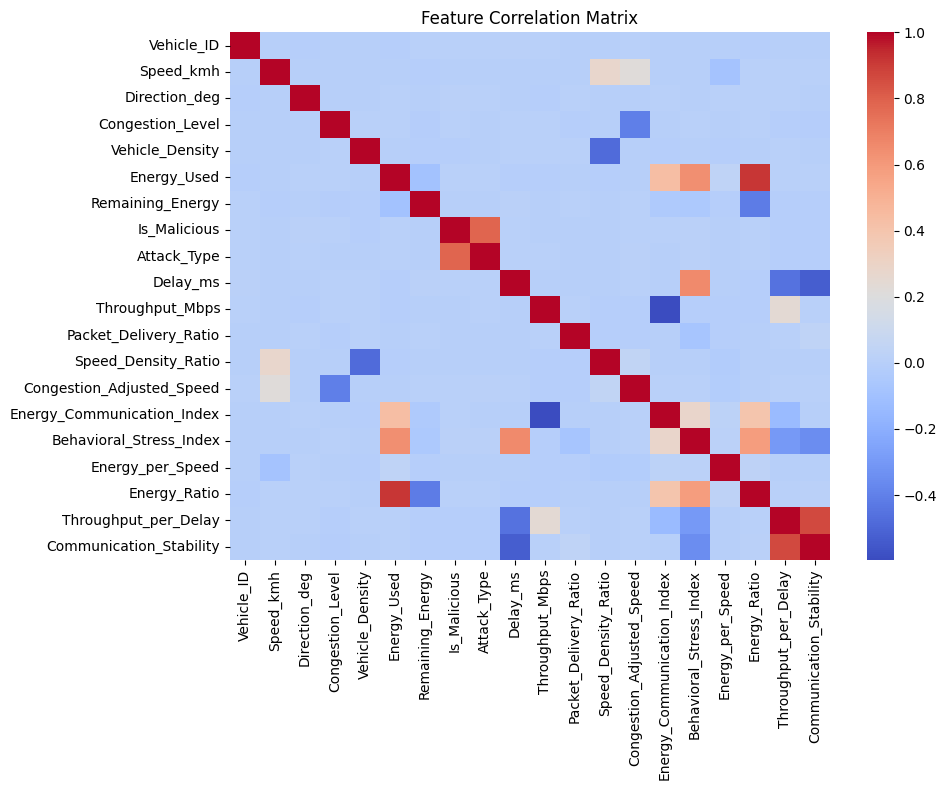

In [6]:
# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

**3o metodo ISOLATION FOREST**

In [17]:
# 1. Identifichiamo i veicoli sani e quelli maliziosi
# Un veicolo è malizioso se ha ALMENO un record con Is_Malicious == 1
malicious_vehicles = df[df['Is_Malicious'] == 1]['Vehicle_ID'].unique()

# 2. CREAZIONE DEL DATASET DISTILLATO
distilled_data = []

for v_id, group in df.groupby('Vehicle_ID'):
    if v_id in malicious_vehicles:
        # Per i MALIZIOSI: prendiamo solo i record di attacco e facciamo la media
        # (Se l'attacco è un singolo istante, la media restituirà quel valore)
        target_records = group[group['Is_Malicious'] == 1]
        v_profile = target_records.mean(numeric_only=True)
    else:
        # Per i SANI: facciamo la media di tutti i loro record (tutti 0)
        v_profile = group.mean(numeric_only=True)
    
    distilled_data.append(v_profile)

# 3. Creazione del dataframe finale
df_distilled = pd.DataFrame(distilled_data)

# 5. Training dell'Isolation Forest sul dataset "Pulito"
features = ['Delay_ms', 'Throughput_Mbps', 'Energy_Used', 'Packet_Delivery_Ratio']
X = df_distilled[features]

iso_forest = IsolationForest(contamination=0.1, random_state=42)
df_distilled['Pred'] = iso_forest.fit_predict(X)

# 6. Risultati
y_pred = [1 if x == -1 else 0 for x in df_distilled['Pred']]
print(classification_report(df_distilled['Is_Malicious'], y_pred))

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      4064
         1.0       1.00      0.53      0.70       936

    accuracy                           0.91      5000
   macro avg       0.95      0.77      0.82      5000
weighted avg       0.92      0.91      0.90      5000



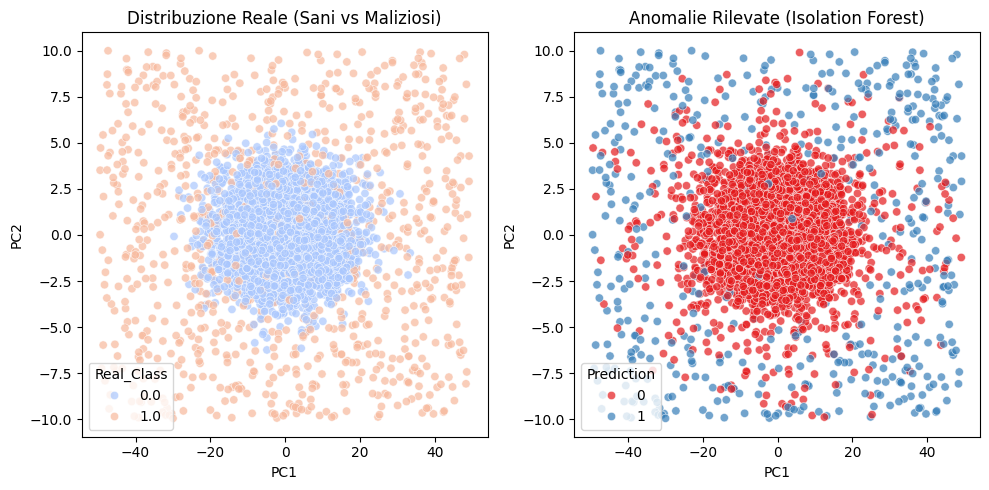

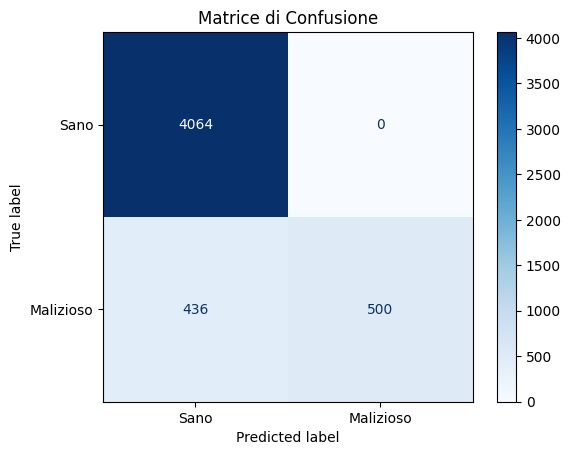

In [22]:
# 1. Riduzione a 2D per la visualizzazione
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_plot['Real_Class'] = df_distilled['Is_Malicious'].values
df_plot['Prediction'] = y_pred

# 2. Plot: Realtà vs Predizione
plt.figure(figsize=(10, 5))

# Subplot 1: Classi Reali
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Real_Class', palette='coolwarm', alpha=0.7)
plt.title('Distribuzione Reale (Sani vs Maliziosi)')

# Subplot 2: Anomalie Rilevate dall\'Isolation Forest
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_plot, x='PC1', y='PC2', hue='Prediction', palette='Set1', alpha=0.7)
plt.title('Anomalie Rilevate (Isolation Forest)')

plt.tight_layout()
plt.show()

# 3. Matrice di Confusione (Fondamentale per la tesi)
cm = confusion_matrix(df_distilled['Is_Malicious'], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sano', 'Malizioso'])
disp.plot(cmap='Blues')
plt.title('Matrice di Confusione')
plt.show()

In [ ]:
df.drop(columns=['Attack_Type'], inplace=True, errors='ignore') 
X = df.drop('Is_Malicious', axis=1)
y = df['Is_Malicious']

**REGRESSIONE LOGISTICA**

c:\Users\GABRIELE\Desktop\Progetto DataScience\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0      0.979     0.532     0.690      9800
           1      0.018     0.430     0.035       200

    accuracy                          0.530     10000
   macro avg      0.499     0.481     0.362     10000
weighted avg      0.959     0.530     0.677     10000



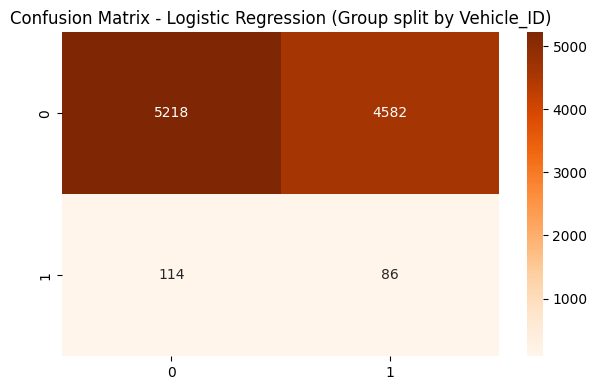

In [ ]:
groups = df["Vehicle_ID"]
# Garantisce che i dati di un veicolo siano tutti nel training o tutti nel test
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

train_idx, test_idx = next(gss.split(X, y, groups=groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

log_reg = LogisticRegression(class_weight='balanced', max_iter=2000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='g', cmap="Oranges")
plt.title("Confusion Matrix - Logistic Regression (Group split by Vehicle_ID)")
plt.tight_layout()
plt.show()

**ISOLATION FOREST**

In [ ]:
df.drop(columns=['Attack_Type'], inplace=True, errors='ignore') 
X = df.drop('Is_Malicious', axis=1)
#isolation forest per rilevare anomalie 
iso_forest = IsolationForest(contamination=0.1, random_state=42)
df['Anomaly_Score'] = iso_forest.fit_predict(X)

#risultati isolation forest
print("\n Isolation Forest Classification Report:")
print(classification_report(y, df['Anomaly_Score'].replace({1:0, -1:1})))   
#matrice di confusione isolation forest
cm_iso = confusion_matrix(y, df['Anomaly_Score'].replace({1:0, -1:1}))
plt.figure(figsize=(6, 4))  
sns.heatmap(cm_iso, annot=True, cmap="Greens", fmt='g')
plt.title("Confusion Matrix - Isolation Forest")
plt.tight_layout()
plt.show()


 Isolation Forest Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94     48966
           1       0.02      0.09      0.03      1034

    accuracy                           0.88     50000
   macro avg       0.50      0.50      0.48     50000
weighted avg       0.96      0.88      0.92     50000



**2o METODO ISOLATION FOREST**

In [14]:
# 1. Calcoliamo la somma delle predizioni dell'Isolation Forest
v_results = df.groupby('Vehicle_ID')['Anomaly_Score'].sum().reset_index()

# 2. Definiamo diverse soglie di "severità"
# Somma 10 -> 0 anomalie
# Somma 8  -> 1 anomalia (9 sani, 1 malizioso: 9-1=8)
# Somma 6  -> 2 anomalie (8 sani, 2 maliziosi: 8-2=6)
# Somma 4  -> 3 anomalie (7 sani, 3 maliziosi: 7-3=4)

#analsi delle prestazioni per ogni soglia

for soglia in [9, 8, 7]:
    # Applichiamo la soglia
    v_results[f'Pred_S{soglia}'] = v_results['Anomaly_Score'].apply(lambda x: 1 if x <= soglia else 0)
    
    # Recuperiamo la verità
    y_true = df.groupby('Vehicle_ID')['Is_Malicious'].max()
    y_pred = v_results[f'Pred_S{soglia}']
    
    report = classification_report(y_true, y_pred, output_dict=True)
    
    print(f"\nSoglia Somma <= {soglia} (Almeno {(10-soglia)//2 + 1 if soglia<10 else 1} record anomali):")
    print(f"-> Precision: {report['1']['precision']:.2f}")
    print(f"-> Recall:    {report['1']['recall']:.2f}")
    print(f"-> F1-Score:  {report['1']['f1-score']:.2f}")


Soglia Somma <= 9 (Almeno 1 record anomali):
-> Precision: 0.19
-> Recall:    0.63
-> F1-Score:  0.29

Soglia Somma <= 8 (Almeno 2 record anomali):
-> Precision: 0.19
-> Recall:    0.63
-> F1-Score:  0.29

Soglia Somma <= 7 (Almeno 2 record anomali):
-> Precision: 0.18
-> Recall:    0.26
-> F1-Score:  0.21


              precision    recall  f1-score   support

           0       0.81      0.37      0.51      4064
           1       0.19      0.63      0.29       936

    accuracy                           0.42      5000
   macro avg       0.50      0.50      0.40      5000
weighted avg       0.69      0.42      0.47      5000



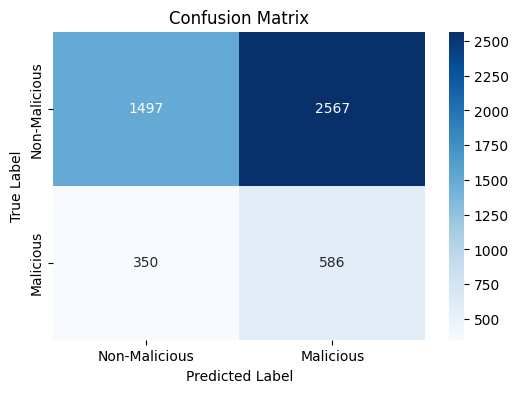

In [ ]:
# 'df' contiene già la colonna 'Anomaly_Score' (-1 e 1) ottenuta dall'Isolation Forest sui 50.000 record
# 1. RAGGRUPPAMENTO PREDIZIONI (Logica della Somma)
v_pred = df.groupby('Vehicle_ID')['Anomaly_Score'].sum().reset_index()

# Se la somma è 10 -> tutti erano 1 (sani) -> assegniamo 0
# Se la somma è < 10 -> almeno uno era -1 (anomalo) -> assegniamo 1
v_pred['Final_Prediction'] = v_pred['Anomaly_Score'].apply(lambda x: 0 if x == 10 else 1)

# 2. RAGGRUPPAMENTO VERITÀ
# Se almeno uno dei 10 record è 1 (malizioso), il veicolo è 1
v_truth = df.groupby('Vehicle_ID')['Is_Malicious'].max().reset_index()

# 3. CONFRONTO FINALE
print(classification_report(v_truth['Is_Malicious'], v_pred['Final_Prediction']))

#matrice di confusione
cm = confusion_matrix(v_truth['Is_Malicious'], v_pred['Final_Prediction'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Malicious', 'Malicious'], yticklabels=['Non-Malicious', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


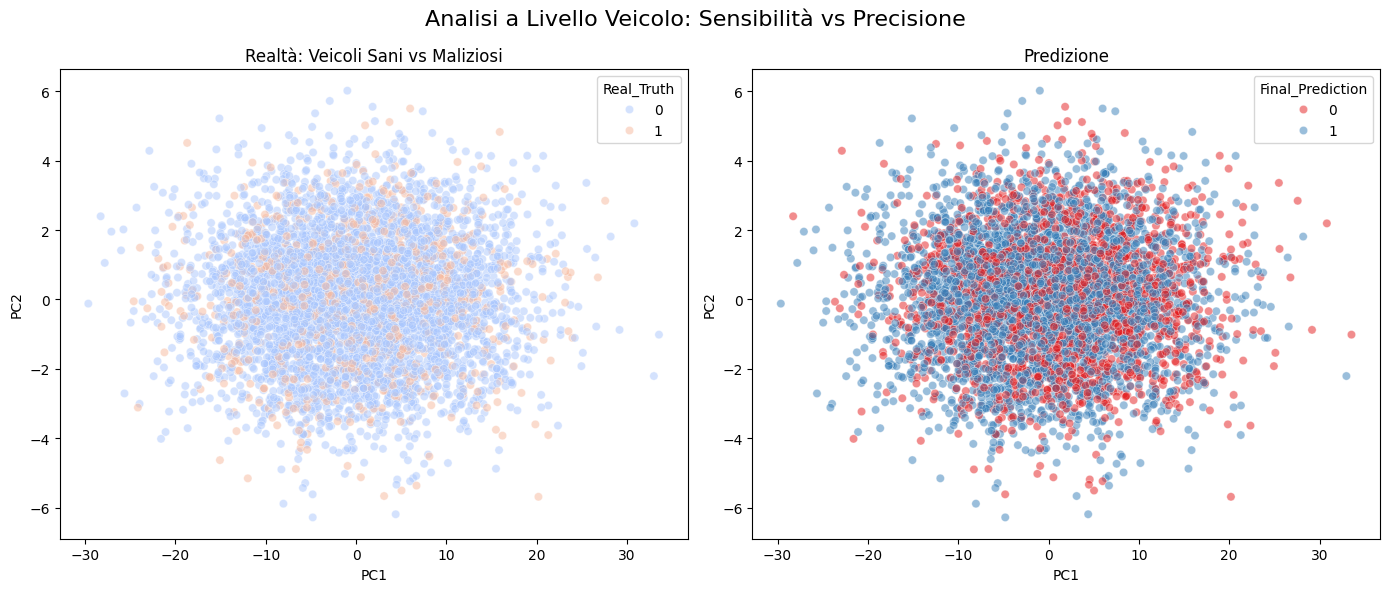

In [ ]:
# 1. Prepariamo i dati medi per i 5000 veicoli
v_features = df.groupby('Vehicle_ID')[['Delay_ms', 'Throughput_Mbps', 'Energy_Used', 'Packet_Delivery_Ratio']].mean().reset_index()

# 2. Uniamo le predizioni e la verità ottenute
v_features['Final_Prediction'] = v_pred['Final_Prediction'].values
v_features['Real_Truth'] = v_truth['Is_Malicious'].values

# 3. PCA a 2 componenti
pca = PCA(n_components=2)
X_pca = pca.fit_transform(v_features[['Delay_ms', 'Throughput_Mbps', 'Energy_Used', 'Packet_Delivery_Ratio']])

v_features['PC1'] = X_pca[:, 0]
v_features['PC2'] = X_pca[:, 1]

# 4. GRAFICO PCA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(data=v_features, x='PC1', y='PC2', hue='Real_Truth', palette='coolwarm', alpha=0.5)
plt.title('Realtà: Veicoli Sani vs Maliziosi')

plt.subplot(1, 2, 2)
sns.scatterplot(data=v_features, x='PC1', y='PC2', hue='Final_Prediction', palette='Set1', alpha=0.5)
plt.title('Predizione')

plt.suptitle('Analisi a Livello Veicolo: Sensibilità vs Precisione', fontsize=16)
plt.tight_layout()
plt.show()